# EEG - Eye Tracking: A Wavelet Packets Approach

## Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
from scipy.signal import medfilt
import pandas as pd

In [12]:
# Train
dir = "Data/dots/EP22/EP22_DOTS1_EEG"
EEG = pd.read_csv(dir + "/substream_0.csv")
labels_x = EEG['x'].values
labels_y = EEG['y'].values

# Test
dirtest = "Data/dots/EP22/EP22_DOTS2_EEG"
EEGtest = pd.read_csv(dirtest + "/substream_0.csv")
labels_xtest = EEGtest['x'].values
labels_ytest = EEGtest['y'].values

## Methods used for baseline drift removal

In [101]:
def getLRF_ts(EEGdata):
    # Gets data averaged over the left, right and front electrodes
    # left side
    Electr_128 = EEGdata['channel_127'].to_numpy()
    Electr_32 = EEGdata['channel_31'].to_numpy()
    Electr_38 = EEGdata['channel_37'].to_numpy()
    EEGleft = (Electr_128 + Electr_32 + Electr_38) / 3
    
    # Right side
    Electr_125 = EEGdata['channel_124'].to_numpy()
    Electr_1 = EEGdata['channel_0'].to_numpy()
    Electr_121 = EEGdata['channel_120'].to_numpy()
    EEGright = (Electr_125 + Electr_1 + Electr_121) / 3

    # front (node 17)
    EEGfront = EEGdata['channel_16'].to_numpy()
    return medfilt(EEGleft, 5), medfilt(EEGright, 5), medfilt(EEGfront, 5)


def remBaseline(EEGdata, wv_type='db4', toremove=[0,7,8]):
    # Removes baseline drift from EEG signal
    # Input: EEG signal
    # Output: EEG signal with baseline removed
   
    db = pywt.Wavelet(wv_type)
    levels = 8
    cA, cD1, cD2, cD3, cD4, cD5, cD6, cD7, cD8 = pywt.wavedec(EEGdata, db, level=levels)
    coeffs = [cA, cD1, cD2, cD3, cD4, cD5, cD6, cD7, cD8]

    for j in toremove:
        coeffs[j] = np.zeros(coeffs[j].shape)
    
    baseline_rem = pywt.waverec(coeffs, db)
    if EEGdata.shape != baseline_rem.shape:
        baseline_rem = baseline_rem[:-1]
    return np.array(baseline_rem), EEGdata - np.array(baseline_rem)

def getBaseRemoveData_ts(EEGdata, wv_type, toremove):
    EEGleft, EEGright, EEGfront = getLRF_ts(EEGdata)
    EEGleft_rem, EEGleft_base = remBaseline(EEGleft, wv_type, toremove)
    EEGright_rem, EEGright_base = remBaseline(EEGright, wv_type, toremove)
    EEGfront_rem, EEGfront_base = remBaseline(EEGfront, wv_type, toremove)
    return EEGleft_rem, EEGright_rem, EEGfront_rem, EEGleft_base, EEGright_base, EEGfront_base

def getData(EEG, blr=True, wv_type='db4', toremove=[0,7,8]):
    # returns baseline-removed EEG data and labels for whole time series
    # EEGdata is left, right and front averaged data concatenated for linear regression
    if blr:
        EEGleft_rem, EEGright_rem, EEGfront_rem, _, _, _ = getBaseRemoveData_ts(EEG, wv_type, toremove)
    else:
        EEGleft_rem, EEGright_rem, EEGfront_rem = getLRF_ts(EEG)
    EEGdata = np.transpose(np.vstack(((EEGleft_rem, EEGright_rem, EEGfront_rem))))
    return EEGdata

def getLinRegression(EEGs, labels, EEGtest=[], predict=False):
    # add assert here to make sure EEGs and labels have the same dimensions 
    fit = LinearRegression().fit(EEGs, labels.reshape((-1,1)))
    if predict:
        return fit.predict(EEGtest)
    else:
        return fit

def energy(cD):
        # Calculates the energy of the detail coefficients
        return np.sum(cD)

## Regression

### Comparison of Baseline Drift with no Baseline Drift

In [102]:
TR = [0,7,8]

# Get training and testing data for linear regression

EEGdata_ts = getData(EEG, toremove=TR)
EEGdata_norem = getData(EEG, blr=False)

EEGtest_ts = getData(EEGtest, toremove=TR)
EEGtest_norem = getData(EEGtest, blr=False)


# Perform linear regression

fitx = getLinRegression(EEGdata_ts, labels_x, predict=False)
fitx_norem = getLinRegression(EEGdata_norem, labels_x, predict=False)

fity = getLinRegression(EEGdata_ts, labels_y, predict=False)
fity_norem = getLinRegression(EEGdata_norem, labels_y, predict=False)


# Predict

predx = fitx.predict(EEGtest_ts)
predx_norem = fitx_norem.predict(EEGtest_norem)

predy = fity.predict(EEGtest_ts)
predy_norem = fity_norem.predict(EEGtest_norem)

Text(0.5, 1.0, 'EEGfront with and without BLR Patient22 Stream2')

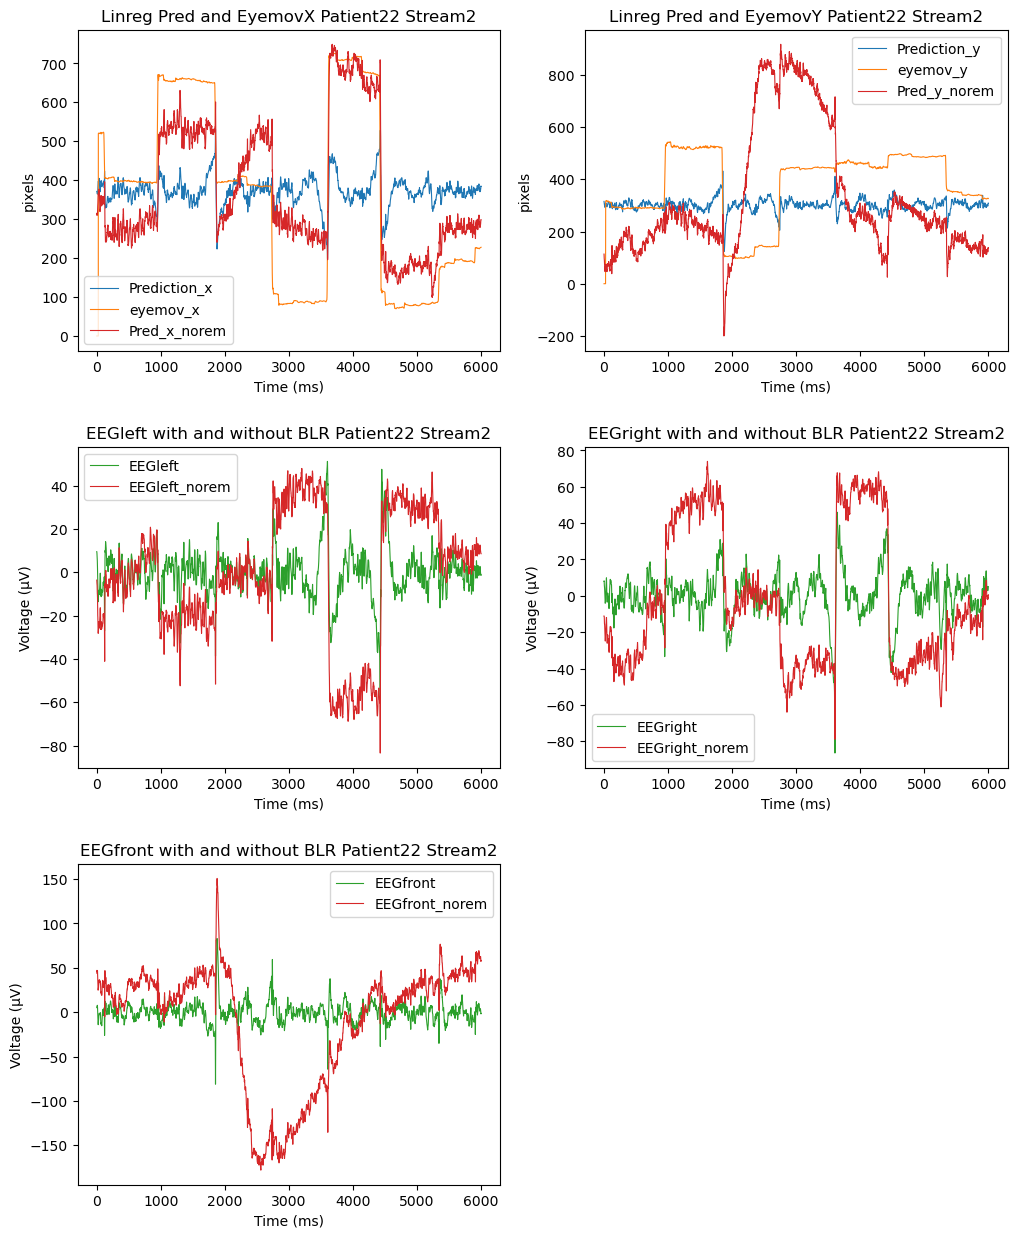

In [103]:
min_t = 0
max_t = 6000

plt.rcParams['figure.figsize'] = [12, 15]
plt.rc('lines', linewidth=.8)
plt.subplots_adjust(hspace=.3)

plt.subplot(3, 2, 1)
plt.plot(range(min_t,max_t), predx[min_t:max_t], label='Prediction_x')
plt.plot(range(min_t,max_t), labels_xtest[min_t:max_t], label='eyemov_x')
plt.plot(range(min_t,max_t), predx_norem[min_t:max_t], label='Pred_x_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("pixels")
plt.title("Linreg Pred and EyemovX Patient22 Stream2")

plt.subplot(3, 2, 2)
plt.plot(range(min_t,max_t), predy[min_t:max_t], label='Prediction_y')
plt.plot(range(min_t,max_t), labels_ytest[min_t:max_t], label='eyemov_y')
plt.plot(range(min_t,max_t), predy_norem[min_t:max_t], label='Pred_y_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("pixels")
plt.title("Linreg Pred and EyemovY Patient22 Stream2")

plt.subplot(3, 2, 3)
plt.plot(range(min_t,max_t), EEGtest_ts[min_t:max_t,0], label='EEGleft', color='tab:green')
plt.plot(range(min_t,max_t), EEGtest_norem[min_t:max_t,0], label='EEGleft_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("EEGleft with and without BLR Patient22 Stream2")

plt.subplot(3, 2, 4)
plt.plot(range(min_t,max_t), EEGtest_ts[min_t:max_t,1], label='EEGright', color='tab:green')
plt.plot(range(min_t,max_t), EEGtest_norem[min_t:max_t,1], label='EEGright_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("EEGright with and without BLR Patient22 Stream2")

plt.subplot(3, 2, 5)
plt.plot(range(min_t,max_t), EEGtest_ts[min_t:max_t,2], label='EEGfront', color='tab:green')
plt.plot(range(min_t,max_t), EEGtest_norem[min_t:max_t,2], label='EEGfront_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("EEGfront with and without BLR Patient22 Stream2")

### Calculate MSE

In [104]:
# Calculate MSE
MSE_y = mean_squared_error(labels_ytest, predy)
MSE_x = mean_squared_error(labels_xtest, predx)

print("MSE_y: ", MSE_y)
print("MSE_x: ", MSE_x)

MSE_y_norem = mean_squared_error(labels_ytest, predy_norem)
MSE_x_norem = mean_squared_error(labels_xtest, predx_norem)

print("MSE_y_norem: ", MSE_y_norem)
print("MSE_x_norem: ", MSE_x_norem)

MSE_y:  26624.641515336247
MSE_x:  42622.412126356314
MSE_y_norem:  31144.46285110553
MSE_x_norem:  16567.62271709905


## Experimental

In [107]:
def getBaseRemoveData_ts(EEGdata, wv_type, toremove, leftthresh=60, rightthresh=60, frontthresh=100):
    EEGleft_rem, EEGright_rem, EEGfront_rem = getLRF_ts(EEGdata)
    EEGleft_base = np.zeros(EEGleft_rem.shape)
    EEGright_base = np.zeros(EEGright_rem.shape)
    EEGfront_base = np.zeros(EEGfront_rem.shape)
    if np.max(EEGleft_rem) - np.min(EEGleft_rem) < leftthresh:
        EEGleft_rem, EEGleft_base = remBaseline(EEGleft_rem, wv_type, toremove)
    if np.max(EEGright_rem) - np.min(EEGright_rem) < rightthresh:
        EEGright_rem, EEGright_base = remBaseline(EEGright_rem, wv_type, toremove)
    if np.max(EEGfront_rem) - np.min(EEGfront_rem) < frontthresh:
        EEGfront_rem, EEGfront_base = remBaseline(EEGfront_rem, wv_type, toremove)
    return EEGleft_rem, EEGright_rem, EEGfront_rem, EEGleft_base, EEGright_base, EEGfront_base

def getData(EEG, blr=True, wv_type='db4', toremove=[0,7,8], batch_size=400):
    # returns baseline-removed EEG data and labels for whole time series
    # EEGdata is left, right and front averaged data concatenated for linear regression
    if blr:
        q, mod = divmod(len(EEG), batch_size)
        EEGleft_rem = np.zeros(len(EEG))
        EEGright_rem = np.zeros(len(EEG))
        EEGfront_rem = np.zeros(len(EEG))

        for i in range(q):
            EEGleft_rem[i*batch_size:(i+1)*batch_size], EEGright_rem[i*batch_size:(i+1)*batch_size], EEGfront_rem[i*batch_size:(i+1)*batch_size], _, _, _ = getBaseRemoveData_ts(EEG[i*batch_size:(i+1)*batch_size], wv_type, toremove)
        EEGleft_rem[q*batch_size:], EEGright_rem[q*batch_size:], EEGfront_rem[q*batch_size:], _, _, _ = getBaseRemoveData_ts(EEG[q*batch_size:], wv_type, toremove)

        # EEGleft_rem, EEGright_rem, EEGfront_rem, _, _, _ = getBaseRemoveData_ts(EEG, wv_type, toremove)
    else:
        EEGleft_rem, EEGright_rem, EEGfront_rem = getLRF_ts(EEG)
    EEGdata = np.transpose(np.vstack(((EEGleft_rem, EEGright_rem, EEGfront_rem))))
    return EEGdata

In [108]:
TR = [0,7,8]

# Get training and testing data for linear regression

EEGdata_ts = getData(EEG, toremove=TR)
EEGdata_norem = getData(EEG, blr=False)

EEGtest_ts = getData(EEGtest, toremove=TR)
EEGtest_norem = getData(EEGtest, blr=False)


# Perform linear regression

fitx = getLinRegression(EEGdata_ts, labels_x, predict=False)
fitx_norem = getLinRegression(EEGdata_norem, labels_x, predict=False)

fity = getLinRegression(EEGdata_ts, labels_y, predict=False)
fity_norem = getLinRegression(EEGdata_norem, labels_y, predict=False)


# Predict

predx_exp = fitx.predict(EEGtest_ts)
predx_norem = fitx_norem.predict(EEGtest_norem)

predy_exp = fity.predict(EEGtest_ts)
predy_norem = fity_norem.predict(EEGtest_norem)

/opt/homebrew/Caskroom/miniforge/base/envs/kf_bf/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Text(0.5, 1.0, 'EEGfront with and without BLR Patient22 Stream2')

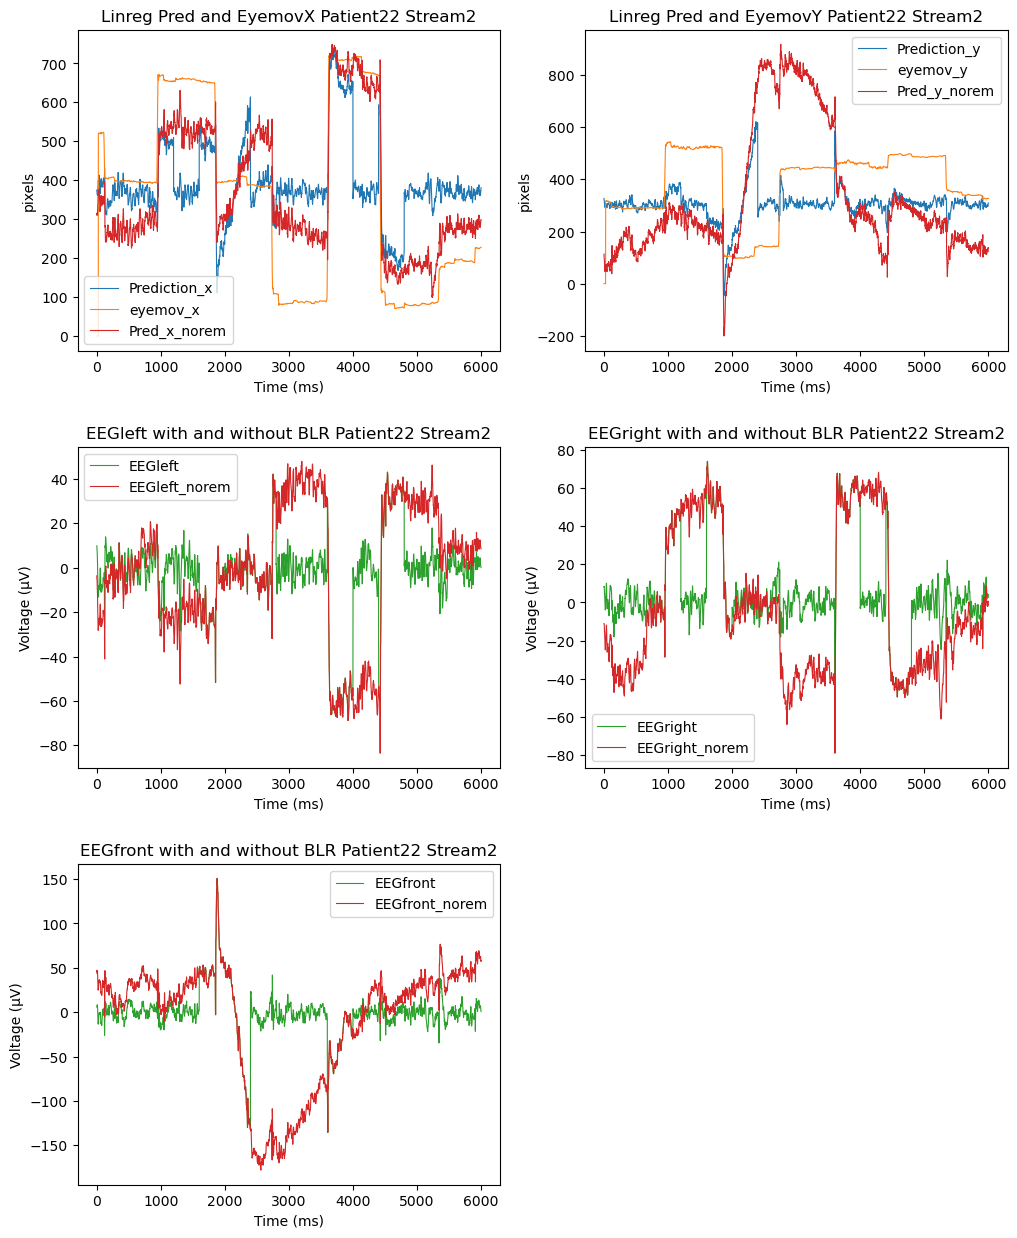

In [109]:
min_t = 0000
max_t = 6000

plt.rcParams['figure.figsize'] = [12, 15]
plt.rc('lines', linewidth=.8)
plt.subplots_adjust(hspace=.3)

plt.subplot(3, 2, 1)
plt.plot(range(min_t,max_t), predx_exp[min_t:max_t], label='Prediction_x')
plt.plot(range(min_t,max_t), labels_xtest[min_t:max_t], label='eyemov_x')
plt.plot(range(min_t,max_t), predx_norem[min_t:max_t], label='Pred_x_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("pixels")
plt.title("Linreg Pred and EyemovX Patient22 Stream2")

plt.subplot(3, 2, 2)
plt.plot(range(min_t,max_t), predy_exp[min_t:max_t], label='Prediction_y')
plt.plot(range(min_t,max_t), labels_ytest[min_t:max_t], label='eyemov_y')
plt.plot(range(min_t,max_t), predy_norem[min_t:max_t], label='Pred_y_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("pixels")
plt.title("Linreg Pred and EyemovY Patient22 Stream2")

plt.subplot(3, 2, 3)
plt.plot(range(min_t,max_t), EEGtest_ts[min_t:max_t,0], label='EEGleft', color='tab:green')
plt.plot(range(min_t,max_t), EEGtest_norem[min_t:max_t,0], label='EEGleft_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("EEGleft with and without BLR Patient22 Stream2")

plt.subplot(3, 2, 4)
plt.plot(range(min_t,max_t), EEGtest_ts[min_t:max_t,1], label='EEGright', color='tab:green')
plt.plot(range(min_t,max_t), EEGtest_norem[min_t:max_t,1], label='EEGright_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("EEGright with and without BLR Patient22 Stream2")

plt.subplot(3, 2, 5)
plt.plot(range(min_t,max_t), EEGtest_ts[min_t:max_t,2], label='EEGfront', color='tab:green')
plt.plot(range(min_t,max_t), EEGtest_norem[min_t:max_t,2], label='EEGfront_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("EEGfront with and without BLR Patient22 Stream2")

In [113]:
# Calculate MSE

MSE_y_norem = mean_squared_error(labels_ytest, predy_norem)
MSE_x_norem = mean_squared_error(labels_xtest, predx_norem)

print("MSE_y_norem: ", MSE_y_norem)
print("MSE_x_norem: ", MSE_x_norem)

MSE_y = mean_squared_error(labels_ytest, predy)
MSE_x = mean_squared_error(labels_xtest, predx)

print("MSE_y: ", MSE_y)
print("MSE_x: ", MSE_x)



MSE_y_exp = mean_squared_error(labels_ytest, predy_exp)
MSE_x_exp = mean_squared_error(labels_xtest, predx_exp)

print("MSE_y_exp: ", MSE_y_exp)
print("MSE_x_exp: ", MSE_x_exp)


MSE_y_norem:  31144.46285110553
MSE_x_norem:  16567.62271709905
MSE_y:  26624.641515336247
MSE_x:  42622.412126356314
MSE_y_exp:  25540.27306958382
MSE_x_exp:  33806.05108975982


## Code for Plot Generation for Paper